In [1]:
import pickle
import numpy as np
import pandas as pd 

In [4]:
# loadind train and test data 

with open("/content/drive/My Drive/MSC/train_data_label_coherence_hierarchy_1.pkl","rb") as file:
  df_train_data = pickle.load(file)


with open("/content/drive/My Drive/MSC/test_data_label_coherence_hierarchy_1.pkl","rb") as file:
  df_test_data = pickle.load(file)

In [ ]:
#intslall google news pre-trained word2vec

!wget -P /root/input/ -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

--2020-11-16 05:50:00--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.224.99
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.224.99|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘/root/input/GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  34.8MB/s    in 46s     

2020-11-16 05:50:46 (34.3 MB/s) - ‘/root/input/GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [ ]:
!pip install gensim
from gensim.models import KeyedVectors

EMBEDDING_FILE = '/root/input/GoogleNews-vectors-negative300.bin.gz' # from above
word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

FileNotFoundError: ignored

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
from gensim.models import Word2Vec
# w2v_model = Word2Vec(min_count=20,window=10,size=70,sample=6e-5,alpha=0.03,min_alpha=0.0007)

w2v_model=Word2Vec.load("/content/drive/MyDrive/MSC/word2vec_trained.model")

w2v_model.wv.vocab["test"].index

321

In [35]:
w2v_model.wv.vocab["test"].index

321

In [ ]:
#training own word2vec

from gensim.models import Word2Vec
w2v_model = Word2Vec(min_count=20,window=10,size=70,sample=6e-5,alpha=0.03,min_alpha=0.0007)
w2v_model.build_vocab(df_train_data.body_tokens_clean_stemmer, progress_per=10000)
# w2v_model.train(df_train_data.body_tokens_clean_stemmer,epochs=50,total_examples=df_train_data.shape[0])

w2v_model.train(df_train_data.body_tokens_clean_stemmer, total_examples=w2v_model.corpus_count, epochs=30)

(185154558, 311449380)

In [ ]:
w2v_model.save("/content/drive/MyDrive/MSC/word2vec_trained.model")

In [ ]:
w2v_model.wv.vectors.shape

(19076, 70)

In [6]:
# prepartion of weights matrix 

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# MAX_NB_WORDS =w2v_model.wv.vectors.shape[0]

SENTENCE_LENGTH =250

# tokenizer = Tokenizer(nb_words=MAX_NB_WORDS)
# tokenizer.fit_on_texts(df_train_data.body_tokens_clean_stemmer.apply(lambda x: " ".join(x)))

# word_index = tokenizer.word_index

word2index = {token: token_index for token_index, token in enumerate(w2v_model.wv.index2word)} 
x_train = df_train_data.body_tokens_clean_stemmer.apply(lambda x:[word2index[i] if i in w2v_model.wv.vocab else 0 for i in x])
x_test = df_test_data.body_tokens_clean_stemmer.apply(lambda x:[word2index[i] if i in w2v_model.wv.vocab else 0 for i in x])



# x_train = np.array()



x_train = pad_sequences(x_train,maxlen = SENTENCE_LENGTH, padding ="post",truncating="post",value =0)
x_test = pad_sequences(x_test,maxlen = SENTENCE_LENGTH, padding ="post",truncating="post",value =0)

In [10]:
# load Model 


from sklearn.preprocessing import MultiLabelBinarizer
multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(df_train_data.ylabel_hierarchy_upto_level1)
labels = multilabel_binarizer.classes_
y_train = multilabel_binarizer.transform(df_train_data.ylabel_hierarchy_upto_level1)
y_test = multilabel_binarizer.transform(df_test_data.ylabel_hierarchy_upto_level1)

import tensorflow as tf

from keras.models import Sequential
from keras.layers import *  
from keras.layers import Dense, Activation, Embedding, Flatten, GlobalMaxPool1D, Dropout, LSTM
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.losses import binary_crossentropy
from keras.optimizers import Adam
from keras.optimizers import SGD

w2v_weights = w2v_model.wv.vectors
vocab_size, embedding_size = w2v_weights.shape

model = Sequential()
_embding = Embedding(input_dim=vocab_size,output_dim=embedding_size,weights =[w2v_weights],input_length=SENTENCE_LENGTH, trainable=True )
model.add(_embding)
# model.add(Bidirectional(LSTM(100)))
model.add(LSTM(200, dropout=0.2, recurrent_dropout=0.2))
model.add(Dropout(0.2))
model.add(Dense(128,activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(64,activation="relu"))
model.add(Dense(len(labels), activation='sigmoid'))
model.compile(optimizer='Adam', loss='poisson', metrics=[tf.keras.metrics.Precision(top_k=1),tf.keras.metrics.Recall(top_k =1),"categorical_accuracy"])
model.summary()

# model.save_weights("/content/drive/My Drive/MSC/MODEL_02_level01_v1.md5")

model.load_weights("/content/drive/My Drive/MSC/MODEL_02_level02_v2.md5")

y_pred =model.predict(x_test)

from tensorflow.compat.v1.metrics import precision_at_k

for i in np.arange(3):
  m = tf.keras.metrics.Precision(top_k=i+1)
  m.update_state(y_test, y_pred)
  print(f"For precesion @ {i+1}, {m.result().numpy()}")



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 250, 70)           1335320   
_________________________________________________________________
lstm_1 (LSTM)                (None, 200)               216800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               25728     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 138)              

NotFoundError: ignored

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(df_train_data.ylabel_hierarchy_upto_level0)
labels = multilabel_binarizer.classes_
y_train = multilabel_binarizer.transform(df_train_data.ylabel_hierarchy_upto_level0)
y_test = multilabel_binarizer.transform(df_test_data.ylabel_hierarchy_upto_level0)

In [ ]:
import tensorflow as tf

from keras.models import Sequential
from keras.layers import *  
from keras.layers import Dense, Activation, Embedding, Flatten, GlobalMaxPool1D, Dropout, LSTM
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.losses import binary_crossentropy
from keras.optimizers import Adam
from keras.optimizers import SGD

w2v_weights = w2v_model.wv.vectors
vocab_size, embedding_size = w2v_weights.shape

model = Sequential()
_embding = Embedding(input_dim=vocab_size,output_dim=embedding_size,weights =[w2v_weights],input_length=SENTENCE_LENGTH, trainable=True )
model.add(_embding)
# model.add(Bidirectional(LSTM(100)))
model.add(LSTM(200, dropout=0.2, recurrent_dropout=0.2))
model.add(Dropout(0.2))
model.add(Dense(128,activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(64,activation="relu"))
model.add(Dense(len(labels), activation='sigmoid'))
model.compile(optimizer='Adam', loss='poisson', metrics=[tf.keras.metrics.Precision(top_k=1),tf.keras.metrics.Recall(top_k =1),"categorical_accuracy"])
model.summary()

history = model.fit(x_train, y_train,epochs=60,batch_size=1000,validation_data=(x_test,y_test))

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 250, 70)           1335320   
_________________________________________________________________
lstm_3 (LSTM)                (None, 200)               216800    
_________________________________________________________________
dropout_6 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               25728     
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_11 (Dense)             (None, 61)               

In [ ]:
history.history.keys()

dict_keys(['loss', 'precision_3', 'recall_2', 'categorical_accuracy', 'val_loss', 'val_precision_3', 'val_recall_2', 'val_categorical_accuracy'])

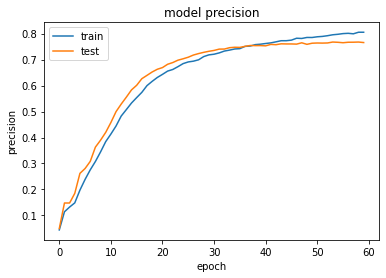

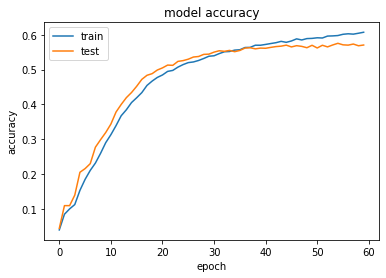

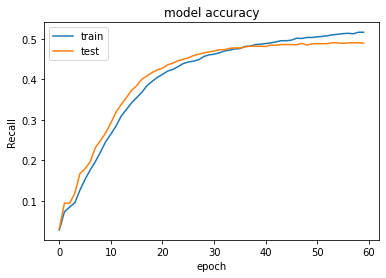

In [ ]:
import matplotlib.pyplot as plt


plt.plot(history.history['precision_3'])
plt.plot(history.history['val_precision_3'])
plt.title('model precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


plt.plot(history.history['recall_2'])
plt.plot(history.history['val_recall_2'])
plt.title('model accuracy')
plt.ylabel('Recall')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model.save_weights("/content/drive/My Drive/MSC/MODEL_02_level01_v1.md5")

In [7]:
# running model for predicting level=1


from sklearn.preprocessing import MultiLabelBinarizer
multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(df_train_data.ylabel_hierarchy_upto_level1)
labels = multilabel_binarizer.classes_
y_train = multilabel_binarizer.transform(df_train_data.ylabel_hierarchy_upto_level1)
y_test = multilabel_binarizer.transform(df_test_data.ylabel_hierarchy_upto_level1)

In [39]:
len(labels)

138

In [8]:
import tensorflow as tf
import os

from keras.models import Sequential
from keras.layers import *  
from keras.layers import Dense, Activation, Embedding, Flatten, GlobalMaxPool1D, Dropout, LSTM
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.losses import binary_crossentropy
from keras.optimizers import Adam
from keras.optimizers import SGD

w2v_weights = w2v_model.wv.vectors
vocab_size, embedding_size = w2v_weights.shape

model = Sequential()
_embding = Embedding(input_dim=vocab_size,output_dim=embedding_size,weights =[w2v_weights],input_length=SENTENCE_LENGTH, trainable=True )
model.add(_embding)
# model.add(Bidirectional(LSTM(100)))
model.add(LSTM(200, dropout=0.2, recurrent_dropout=0.2))
model.add(Dropout(0.2))
model.add(Dense(128,activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(64,activation="relu"))
model.add(Dense(len(labels), activation='sigmoid'))
model.compile(optimizer='Adam', loss='poisson', metrics=[tf.keras.metrics.Precision(top_k=1),"categorical_accuracy"])
model.summary()

checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)


history = model.fit(x_train, y_train,epochs=60,batch_size=1000,validation_data=(x_test,y_test),callbacks=[cp_callback])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 250, 70)           1335320   
_________________________________________________________________
lstm (LSTM)                  (None, 200)               216800    
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               25728     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 138)               8

In [9]:
model.save_weights("/content/drive/My Drive/MSC/MODEL_02_level02_v2.hd5")

In [ ]:
history.history.keys()

dict_keys(['loss', 'precision_4', 'categorical_accuracy', 'val_loss', 'val_precision_4', 'val_categorical_accuracy'])

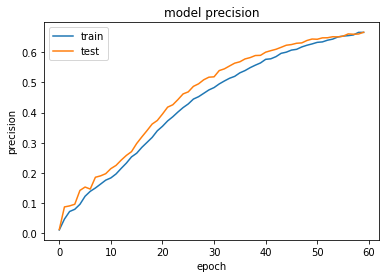

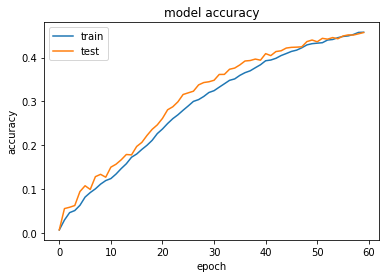

In [ ]:
import matplotlib.pyplot as plt


plt.plot(history.history['precision_4'])
plt.plot(history.history['val_precision_4'])
plt.title('model precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# running model for predicting level=1


from sklearn.preprocessing import MultiLabelBinarizer
multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(df_train_data.ylabel_hierarchy_upto_level2)
labels = multilabel_binarizer.classes_
y_train = multilabel_binarizer.transform(df_train_data.ylabel_hierarchy_upto_level2)
y_test = multilabel_binarizer.transform(df_test_data.ylabel_hierarchy_upto_level2)

In [ ]:
import tensorflow as tf
import os

from keras.models import Sequential
from keras.layers import *  
from keras.layers import Dense, Activation, Embedding, Flatten, GlobalMaxPool1D, Dropout, LSTM
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.losses import binary_crossentropy
from keras.optimizers import Adam
from keras.optimizers import SGD

w2v_weights = w2v_model.wv.vectors
vocab_size, embedding_size = w2v_weights.shape

model = Sequential()
_embding = Embedding(input_dim=vocab_size,output_dim=embedding_size,weights =[w2v_weights],input_length=SENTENCE_LENGTH, trainable=True )
model.add(_embding)
# model.add(Bidirectional(LSTM(100)))
model.add(LSTM(200, dropout=0.2, recurrent_dropout=0.2))
model.add(Dropout(0.2))
model.add(Dense(128,activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(64,activation="relu"))
model.add(Dense(len(labels), activation='sigmoid'))
model.compile(optimizer='Adam', loss='poisson', metrics=[tf.keras.metrics.Precision(top_k=1),tf.keras.metrics.Recall(top_k =1),"categorical_accuracy"])
model.summary()

checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)


history = model.fit(x_train, y_train,epochs=60,batch_size=1000,validation_data=(x_test,y_test),callbacks=[cp_callback])

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 250, 70)           1335320   
_________________________________________________________________
lstm_5 (LSTM)                (None, 200)               216800    
_________________________________________________________________
dropout_10 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 128)               25728     
_________________________________________________________________
dropout_11 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_17 (Dense)             (None, 159)              

In [ ]:
history.history.keys()

dict_keys(['loss', 'precision_5', 'recall_3', 'categorical_accuracy', 'val_loss', 'val_precision_5', 'val_recall_3', 'val_categorical_accuracy'])

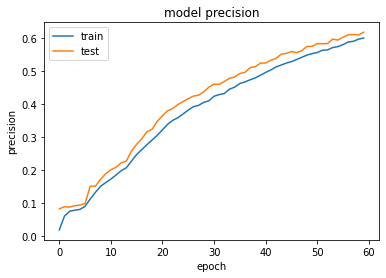

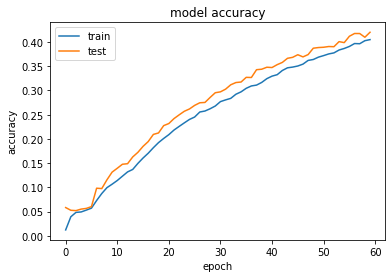

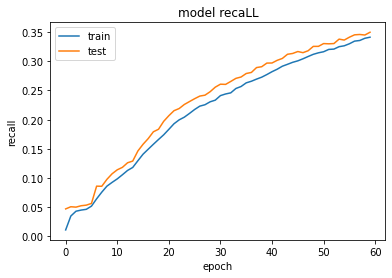

In [ ]:
import matplotlib.pyplot as plt


plt.plot(history.history['precision_5'])
plt.plot(history.history['val_precision_5'])
plt.title('model precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['recall_3'])
plt.plot(history.history['val_recall_3'])
plt.title('model recaLL')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model.save_weights("/content/drive/My Drive/MSC/MODEL_02_level03_v1.md5")